In [ ]:
#!pip install -qU python-gdcm pydicom pylibjpeg
#!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist/nightly --upgrade nvidia-dali-nightly-cuda110

In [1]:
!pip install /kaggle/input/rsna-whl/{pydicom-2.3.1-py3-none-any.whl,pylibjpeg-1.4.0-py3-none-any.whl,python_gdcm-3.0.20-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl}
!pip install /kaggle/input/nvidia-dali-wheel/nvidia_dali_nightly_cuda110-1.22.0.dev20221213-6757685-py3-none-manylinux2014_x86_64.whl
!pip install /kaggle/input/nvidia-dali-wheel/dicomsdl-0.109.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl


Processing /kaggle/input/rsna-whl/pydicom-2.3.1-py3-none-any.whl
Processing /kaggle/input/rsna-whl/pylibjpeg-1.4.0-py3-none-any.whl
Processing /kaggle/input/rsna-whl/python_gdcm-3.0.20-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
pydicom is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Processing /kaggle/input/nvidia-dali-wheel/nvidia_dali_nightly_cuda110-1.22.0.dev20221213-6757685-py3-none-manylinux2014_x86_64.whl
Processing /kaggle/input/nvidia-dali-wheel/dicomsdl-0.109.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl


In [3]:
%%writefile /opt/conda/lib/python3.7/site-packages/nvidia/dali/plugin/pytorch.py

# Copyright (c) 2017-2022, NVIDIA CORPORATION & AFFILIATES. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from nvidia.dali.backend import TensorGPU, TensorListGPU
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
from nvidia.dali import types
from nvidia.dali.plugin.base_iterator import _DaliBaseIterator
from nvidia.dali.plugin.base_iterator import LastBatchPolicy
import torch
import torch.utils.dlpack as torch_dlpack
import ctypes
import numpy as np

to_torch_type = {
    types.DALIDataType.FLOAT:   torch.float32,
    types.DALIDataType.FLOAT64: torch.float64,
    types.DALIDataType.FLOAT16: torch.float16,
    types.DALIDataType.UINT8:   torch.uint8,
    types.DALIDataType.INT8:    torch.int8,
    types.DALIDataType.UINT16:  torch.int16,
    types.DALIDataType.INT16:   torch.int16,
    types.DALIDataType.INT32:   torch.int32,
    types.DALIDataType.INT64:   torch.int64
}


def feed_ndarray(dali_tensor, arr, cuda_stream=None):
    """
    Copy contents of DALI tensor to PyTorch's Tensor.

    Parameters
    ----------
    `dali_tensor` : nvidia.dali.backend.TensorCPU or nvidia.dali.backend.TensorGPU
                    Tensor from which to copy
    `arr` : torch.Tensor
            Destination of the copy
    `cuda_stream` : torch.cuda.Stream, cudaStream_t or any value that can be cast to cudaStream_t.
                    CUDA stream to be used for the copy
                    (if not provided, an internal user stream will be selected)
                    In most cases, using pytorch's current stream is expected (for example,
                    if we are copying to a tensor allocated with torch.zeros(...))
    """
    dali_type = to_torch_type[dali_tensor.dtype]

    assert dali_type == arr.dtype, ("The element type of DALI Tensor/TensorList"
                                    " doesn't match the element type of the target PyTorch Tensor: "
                                    "{} vs {}".format(dali_type, arr.dtype))
    assert dali_tensor.shape() == list(arr.size()), \
        ("Shapes do not match: DALI tensor has size {0}, but PyTorch Tensor has size {1}".
            format(dali_tensor.shape(), list(arr.size())))
    cuda_stream = types._raw_cuda_stream(cuda_stream)

    # turn raw int to a c void pointer
    c_type_pointer = ctypes.c_void_p(arr.data_ptr())
    if isinstance(dali_tensor, (TensorGPU, TensorListGPU)):
        stream = None if cuda_stream is None else ctypes.c_void_p(cuda_stream)
        dali_tensor.copy_to_external(c_type_pointer, stream, non_blocking=True)
    else:
        dali_tensor.copy_to_external(c_type_pointer)
    return arr


class DALIGenericIterator(_DaliBaseIterator):
    """
    General DALI iterator for PyTorch. It can return any number of
    outputs from the DALI pipeline in the form of PyTorch's Tensors.

    Parameters
    ----------
    pipelines : list of nvidia.dali.Pipeline
                List of pipelines to use
    output_map : list of str
                List of strings which maps consecutive outputs
                of DALI pipelines to user specified name.
                Outputs will be returned from iterator as dictionary
                of those names.
                Each name should be distinct
    size : int, default = -1
                Number of samples in the shard for the wrapped pipeline (if there is more than
                one it is a sum)
                Providing -1 means that the iterator will work until StopIteration is raised
                from the inside of iter_setup(). The options `last_batch_policy` and
                `last_batch_padded` don't work in such case. It works with only one pipeline inside
                the iterator.
                Mutually exclusive with `reader_name` argument
    reader_name : str, default = None
                Name of the reader which will be queried to the shard size, number of shards and
                all other properties necessary to count properly the number of relevant and padded
                samples that iterator needs to deal with. It automatically sets `last_batch_policy`
                to PARTIAL when the FILL is used, and `last_batch_padded` accordingly to match
                the reader's configuration
    auto_reset : string or bool, optional, default = False
                Whether the iterator resets itself for the next epoch or it requires reset() to be
                called explicitly.

                It can be one of the following values:

                * ``"no"``, ``False`` or ``None`` - at the end of epoch StopIteration is raised
                  and reset() needs to be called
                * ``"yes"`` or ``"True"``- at the end of epoch StopIteration is raised but reset()
                  is called internally automatically

    dynamic_shape : any, optional,
                Parameter used only for backward compatibility.
    fill_last_batch : bool, optional, default = None
                **Deprecated** Please use ``last_batch_policy`` instead

                Whether to fill the last batch with data up to 'self.batch_size'.
                The iterator would return the first integer multiple
                of self._num_gpus * self.batch_size entries which exceeds 'size'.
                Setting this flag to False will cause the iterator to return
                exactly 'size' entries.
    last_batch_policy: optional, default = LastBatchPolicy.FILL
                What to do with the last batch when there are not enough samples in the epoch
                to fully fill it. See :meth:`nvidia.dali.plugin.base_iterator.LastBatchPolicy`
    last_batch_padded : bool, optional, default = False
                Whether the last batch provided by DALI is padded with the last sample
                or it just wraps up. In the conjunction with ``last_batch_policy`` it tells
                if the iterator returning last batch with data only partially filled with
                data from the current epoch is dropping padding samples or samples from
                the next epoch. If set to ``False`` next
                epoch will end sooner as data from it was consumed but dropped. If set to
                True next epoch would be the same length as the first one. For this to happen,
                the option `pad_last_batch` in the reader needs to be set to True as well.
                It is overwritten when `reader_name` argument is provided
    prepare_first_batch : bool, optional, default = True
                Whether DALI should buffer the first batch right after the creation of the iterator,
                so one batch is already prepared when the iterator is prompted for the data

    Example
    -------
    With the data set ``[1,2,3,4,5,6,7]`` and the batch size 2:

    last_batch_policy = LastBatchPolicy.PARTIAL, last_batch_padded = True  -> last batch = ``[7]``,
    next iteration will return ``[1, 2]``

    last_batch_policy = LastBatchPolicy.PARTIAL, last_batch_padded = False -> last batch = ``[7]``,
    next iteration will return ``[2, 3]``

    last_batch_policy = LastBatchPolicy.FILL, last_batch_padded = True   -> last batch = ``[7, 7]``,
    next iteration will return ``[1, 2]``

    last_batch_policy = LastBatchPolicy.FILL, last_batch_padded = False  -> last batch = ``[7, 1]``,
    next iteration will return ``[2, 3]``

    last_batch_policy = LastBatchPolicy.DROP, last_batch_padded = True   -> last batch = ``[5, 6]``,
    next iteration will return ``[1, 2]``

    last_batch_policy = LastBatchPolicy.DROP, last_batch_padded = False  -> last batch = ``[5, 6]``,
    next iteration will return ``[2, 3]``
    """

    def __init__(self,
                 pipelines,
                 output_map,
                 size=-1,
                 reader_name=None,
                 auto_reset=False,
                 fill_last_batch=None,
                 dynamic_shape=False,
                 last_batch_padded=False,
                 last_batch_policy=LastBatchPolicy.FILL,
                 prepare_first_batch=True):

        # check the assert first as _DaliBaseIterator would run the prefetch
        assert len(set(output_map)) == len(output_map), "output_map names should be distinct"
        self._output_categories = set(output_map)
        self.output_map = output_map

        _DaliBaseIterator.__init__(self,
                                   pipelines,
                                   size,
                                   reader_name,
                                   auto_reset,
                                   fill_last_batch,
                                   last_batch_padded,
                                   last_batch_policy,
                                   prepare_first_batch=prepare_first_batch)

        self._first_batch = None
        if self._prepare_first_batch:
            try:
                self._first_batch = DALIGenericIterator.__next__(self)
                # call to `next` sets _ever_consumed to True but if we are just calling it from
                # here we should set if to False again
                self._ever_consumed = False
            except StopIteration:
                assert False, "It seems that there is no data in the pipeline. This may happen " \
                       "if `last_batch_policy` is set to PARTIAL and the requested batch size is " \
                       "greater than the shard size."

    def __next__(self):
        self._ever_consumed = True
        if self._first_batch is not None:
            batch = self._first_batch
            self._first_batch = None
            return batch

        # Gather outputs
        outputs = self._get_outputs()

        data_batches = [None for i in range(self._num_gpus)]
        for i in range(self._num_gpus):
            dev_id = self._pipes[i].device_id
            # initialize dict for all output categories
            category_outputs = dict()
            # segregate outputs into categories
            for j, out in enumerate(outputs[i]):
                category_outputs[self.output_map[j]] = out

            # Change DALI TensorLists into Tensors
            category_tensors = dict()
            category_shapes = dict()
            for category, out in category_outputs.items():
                category_tensors[category] = out.as_tensor()
                category_shapes[category] = category_tensors[category].shape()

            category_torch_type = dict()
            category_device = dict()
            torch_gpu_device = None
            torch_cpu_device = torch.device('cpu')
            # check category and device
            for category in self._output_categories:
                category_torch_type[category] = to_torch_type[category_tensors[category].dtype]
                if type(category_tensors[category]) is TensorGPU:
                    if not torch_gpu_device:
                        torch_gpu_device = torch.device('cuda', dev_id)
                    category_device[category] = torch_gpu_device
                else:
                    category_device[category] = torch_cpu_device

            pyt_tensors = dict()
            for category in self._output_categories:
                pyt_tensors[category] = torch.empty(category_shapes[category],
                                                    dtype=category_torch_type[category],
                                                    device=category_device[category])

            data_batches[i] = pyt_tensors

            # Copy data from DALI Tensors to torch tensors
            for category, tensor in category_tensors.items():
                if isinstance(tensor, (TensorGPU, TensorListGPU)):
                    # Using same cuda_stream used by torch.zeros to set the memory
                    stream = torch.cuda.current_stream(device=pyt_tensors[category].device)
                    feed_ndarray(tensor, pyt_tensors[category], cuda_stream=stream)
                else:
                    feed_ndarray(tensor, pyt_tensors[category])

        self._schedule_runs()

        self._advance_and_check_drop_last()

        if self._reader_name:
            if_drop, left = self._remove_padded()
            if np.any(if_drop):
                output = []
                for batch, to_copy in zip(data_batches, left):
                    batch = batch.copy()
                    for category in self._output_categories:
                        batch[category] = batch[category][0:to_copy]
                    output.append(batch)
                return output

        else:
            if self._last_batch_policy == LastBatchPolicy.PARTIAL and (
                                          self._counter > self._size) and self._size > 0:
                # First calculate how much data is required to return exactly self._size entries.
                diff = self._num_gpus * self.batch_size - (self._counter - self._size)
                # Figure out how many GPUs to grab from.
                numGPUs_tograb = int(np.ceil(diff / self.batch_size))
                # Figure out how many results to grab from the last GPU
                # (as a fractional GPU batch may be required to bring us
                # right up to self._size).
                mod_diff = diff % self.batch_size
                data_fromlastGPU = mod_diff if mod_diff else self.batch_size

                # Grab the relevant data.
                # 1) Grab everything from the relevant GPUs.
                # 2) Grab the right data from the last GPU.
                # 3) Append data together correctly and return.
                output = data_batches[0:numGPUs_tograb]
                output[-1] = output[-1].copy()
                for category in self._output_categories:
                    output[-1][category] = output[-1][category][0:data_fromlastGPU]
                return output

        return data_batches


class DALIClassificationIterator(DALIGenericIterator):
    """
    DALI iterator for classification tasks for PyTorch. It returns 2 outputs
    (data and label) in the form of PyTorch's Tensor.

    Calling

    .. code-block:: python

       DALIClassificationIterator(pipelines, reader_name)

    is equivalent to calling

    .. code-block:: python

       DALIGenericIterator(pipelines, ["data", "label"], reader_name)

    Parameters
    ----------
    pipelines : list of nvidia.dali.Pipeline
                List of pipelines to use
    size : int, default = -1
                Number of samples in the shard for the wrapped pipeline (if there is more than
                one it is a sum)
                Providing -1 means that the iterator will work until StopIteration is raised
                from the inside of iter_setup(). The options `last_batch_policy` and
                `last_batch_padded` don't work in such case. It works with only one pipeline inside
                the iterator.
                Mutually exclusive with `reader_name` argument
    reader_name : str, default = None
                Name of the reader which will be queried to the shard size, number of shards and
                all other properties necessary to count properly the number of relevant and padded
                samples that iterator needs to deal with. It automatically sets `last_batch_policy`
                to PARTIAL when the FILL is used, and `last_batch_padded` accordingly to match
                the reader's configuration
    auto_reset : string or bool, optional, default = False
                Whether the iterator resets itself for the next epoch or it requires reset() to be
                called explicitly.

                It can be one of the following values:

                * ``"no"``, ``False`` or ``None`` - at the end of epoch StopIteration is raised
                  and reset() needs to be called
                * ``"yes"`` or ``"True"``- at the end of epoch StopIteration is raised but reset()
                  is called internally automatically

    dynamic_shape : any, optional,
                Parameter used only for backward compatibility.
    fill_last_batch : bool, optional, default = None
                **Deprecated** Please use ``last_batch_policy`` instead

                Whether to fill the last batch with data up to 'self.batch_size'.
                The iterator would return the first integer multiple
                of self._num_gpus * self.batch_size entries which exceeds 'size'.
                Setting this flag to False will cause the iterator to return
                exactly 'size' entries.
    last_batch_policy: optional, default = LastBatchPolicy.FILL
                What to do with the last batch when there are not enough samples in the epoch
                to fully fill it. See :meth:`nvidia.dali.plugin.base_iterator.LastBatchPolicy`
    last_batch_padded : bool, optional, default = False
                Whether the last batch provided by DALI is padded with the last sample
                or it just wraps up. In the conjunction with ``last_batch_policy`` it tells
                if the iterator returning last batch with data only partially filled with
                data from the current epoch is dropping padding samples or samples from
                the next epoch. If set to ``False`` next
                epoch will end sooner as data from it was consumed but dropped. If set to
                True next epoch would be the same length as the first one. For this to happen,
                the option `pad_last_batch` in the reader needs to be set to True as well.
                It is overwritten when `reader_name` argument is provided
    prepare_first_batch : bool, optional, default = True
                Whether DALI should buffer the first batch right after the creation of the iterator,
                so one batch is already prepared when the iterator is prompted for the data

    Example
    -------
    With the data set ``[1,2,3,4,5,6,7]`` and the batch size 2:

    last_batch_policy = LastBatchPolicy.PARTIAL, last_batch_padded = True  -> last batch = ``[7]``,
    next iteration will return ``[1, 2]``

    last_batch_policy = LastBatchPolicy.PARTIAL, last_batch_padded = False -> last batch = ``[7]``,
    next iteration will return ``[2, 3]``

    last_batch_policy = LastBatchPolicy.FILL, last_batch_padded = True   -> last batch = ``[7, 7]``,
    next iteration will return ``[1, 2]``

    last_batch_policy = LastBatchPolicy.FILL, last_batch_padded = False  -> last batch = ``[7, 1]``,
    next iteration will return ``[2, 3]``

    last_batch_policy = LastBatchPolicy.DROP, last_batch_padded = True   -> last batch = ``[5, 6]``,
    next iteration will return ``[1, 2]``

    last_batch_policy = LastBatchPolicy.DROP, last_batch_padded = False  -> last batch = ``[5, 6]``,
    next iteration will return ``[2, 3]``
    """

    def __init__(self,
                 pipelines,
                 size=-1,
                 reader_name=None,
                 auto_reset=False,
                 fill_last_batch=None,
                 dynamic_shape=False,
                 last_batch_padded=False,
                 last_batch_policy=LastBatchPolicy.FILL,
                 prepare_first_batch=True):
        super(DALIClassificationIterator, self).__init__(pipelines, ["data", "label"],
                                                         size,
                                                         reader_name=reader_name,
                                                         auto_reset=auto_reset,
                                                         fill_last_batch=fill_last_batch,
                                                         dynamic_shape=dynamic_shape,
                                                         last_batch_padded=last_batch_padded,
                                                         last_batch_policy=last_batch_policy,
                                                         prepare_first_batch=prepare_first_batch)


class TorchPythonFunction(ops.PythonFunctionBase):
    schema_name = "TorchPythonFunction"
    ops.register_cpu_op('TorchPythonFunction')
    ops.register_gpu_op('TorchPythonFunction')

    def _torch_stream_wrapper(self, function, *ins):
        with torch.cuda.stream(self.stream):
            out = function(*ins)
        self.stream.synchronize()
        return out

    def torch_wrapper(self, batch_processing, function, device, *args):
        func = function if device == 'cpu' else \
               lambda *ins: self._torch_stream_wrapper(function, *ins)
        if batch_processing:
            return ops.PythonFunction.function_wrapper_batch(func,
                                                             self.num_outputs,
                                                             torch.utils.dlpack.from_dlpack,
                                                             torch.utils.dlpack.to_dlpack,
                                                             *args)
        else:
            return ops.PythonFunction.function_wrapper_per_sample(func,
                                                                  self.num_outputs,
                                                                  torch_dlpack.from_dlpack,
                                                                  torch_dlpack.to_dlpack,
                                                                  *args)

    def __call__(self, *inputs, **kwargs):
        pipeline = Pipeline.current()
        if pipeline is None:
            Pipeline._raise_no_current_pipeline("TorchPythonFunction")
        if self.stream is None:
            self.stream = torch.cuda.Stream(device=pipeline.device_id)
        return super(TorchPythonFunction, self).__call__(*inputs, **kwargs)

    def __init__(self, function, num_outputs=1, device='cpu', batch_processing=False, **kwargs):
        self.stream = None
        super(TorchPythonFunction, self).__init__(impl_name="DLTensorPythonFunctionImpl",
                                                  function=lambda *ins:
                                                  self.torch_wrapper(batch_processing,
                                                                     function, device,
                                                                     *ins),
                                                  num_outputs=num_outputs, device=device,
                                                  batch_processing=batch_processing, **kwargs)


ops._wrap_op(TorchPythonFunction, "fn", __name__)

Overwriting /opt/conda/lib/python3.7/site-packages/nvidia/dali/plugin/pytorch.py


In [7]:
import os
import sys
import cv2
import glob
import gdcm
import json
import shutil
import pydicom
import numpy as np
import pandas as pd
import seaborn as sns
import pylibjpeg
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from joblib import Parallel, delayed

In [36]:
IMG_PATH = "/kaggle/input/rsna-breast-cancer-detection/test_images/"
test_images = glob.glob(f"{IMG_PATH}*/*.dcm")
    
print("Number of images :", len(test_images))
for names in test_images:
    print(names)

Number of images : 4
/kaggle/input/rsna-breast-cancer-detection/test_images/10008/736471439.dcm
/kaggle/input/rsna-breast-cancer-detection/test_images/10008/361203119.dcm
/kaggle/input/rsna-breast-cancer-detection/test_images/10008/68070693.dcm
/kaggle/input/rsna-breast-cancer-detection/test_images/10008/1591370361.dcm


In [37]:
SAVE_FOLDER = "/kaggle/working/test_images/"
SIZE = 1024

os.makedirs(SAVE_FOLDER, exist_ok=True)

if len(test_images) > 100:
    N_CHUNKS = 4
else:
    N_CHUNKS = 1

CHUNKS = [(len(test_images) / N_CHUNKS * k, len(test_images) / N_CHUNKS * (k + 1)) for k in range(N_CHUNKS)]
CHUNKS = np.array(CHUNKS).astype(int)
    
J2K_FOLDER = "/kaggle/working/tmp/j2k/"
# os.makedirs(J2K_FOLDER, exist_ok=True)


In [38]:
import torch
import torch.nn.functional as F
import nvidia.dali.fn as fn
import nvidia.dali.types as types
from nvidia.dali import pipeline_def
from nvidia.dali.types import DALIDataType
from pydicom.filebase import DicomBytesIO
from nvidia.dali.plugin.pytorch import feed_ndarray, to_torch_type


def convert_dicom_to_j2k(file, save_folder=""):
    patient = file.split('/')[-2]
    image = file.split('/')[-1][:-4]
    dcmfile = pydicom.dcmread(file)

    if dcmfile.file_meta.TransferSyntaxUID == '1.2.840.10008.1.2.4.90':
        with open(file, 'rb') as fp:
            raw = DicomBytesIO(fp.read())
            ds = pydicom.dcmread(raw)
        offset = ds.PixelData.find(b"\x00\x00\x00\x0C")  #<---- the jpeg2000 header info we're looking for
        hackedbitstream = bytearray()
        hackedbitstream.extend(ds.PixelData[offset:])
        with open(save_folder + f"{patient}_{image}.jp2", "wb") as binary_file:
            binary_file.write(hackedbitstream)

# Further cut the empty spaces to accelerate training speed
def fit_image(image,patient_id,im_id,SAVE_FOLDER):
    # X = cv2.imread(fname)
    
    # Some images have narrow exterior "frames" that complicate selection of the main data. Cutting off the frame
    # X = X[5:-5, 5:-5]
    X = image[5:-5, 5:-5]
    # regions of non-empty pixels
    output= cv2.connectedComponentsWithStats((X > 20).astype(np.uint8)[:, :], 8, cv2.CV_32S)

    # stats.shape == (N, 5), where N is the number of regions, 5 dimensions correspond to:
    # left, top, width, height, area_size
    stats = output[2]

    # finding max area which always corresponds to the breast data. 
    idx = stats[1:, 4].argmax() + 1
    x1, y1, w, h = stats[idx][:4]
    x2 = x1 + w
    y2 = y1 + h
    
    # cutting out the breast data
    X_fit = X[y1: y2, x1: x2]
    
    # patient_id, im_id = re.findall('(\d+)_(\d+).png', os.path.basename(fname))[0]
    os.makedirs(SAVE_FOLDER + patient_id, exist_ok=True)
    cv2.imwrite(SAVE_FOLDER + f'{patient_id}/{im_id}.png', X_fit[:, :])

            
@pipeline_def
def j2k_decode_pipeline(j2kfiles):
    jpegs, _ = fn.readers.file(files=j2kfiles)
    images = fn.experimental.decoders.image(jpegs, device='mixed', output_type=types.ANY_DATA, dtype=DALIDataType.UINT16)
    return images

In [39]:
# This block process the first half with convertible J2K files
for chunk in tqdm(CHUNKS):
    os.makedirs(J2K_FOLDER, exist_ok=True)

    _ = Parallel(n_jobs=2)(
        delayed(convert_dicom_to_j2k)(img, save_folder=J2K_FOLDER)
        for img in test_images[chunk[0]: chunk[1]]
    )
    
    j2kfiles = glob.glob(J2K_FOLDER + "*.jp2")

    if not len(j2kfiles):
        continue

    pipe = j2k_decode_pipeline(j2kfiles, batch_size=1, num_threads=2, device_id=0, debug=True)
    pipe.build()

    for i, f in enumerate(j2kfiles):
        patient, image = f.split('/')[-1][:-4].split('_')
        dicom = pydicom.dcmread(IMG_PATH + f"{patient}/{image}.dcm")

        out = pipe.run()

        # Dali -> Torch
        img = out[0][0]
        img_torch = torch.empty(img.shape(), dtype=torch.int16, device="cuda")
        feed_ndarray(img, img_torch, cuda_stream=torch.cuda.current_stream(device=0))
        img = img_torch.float()

        # Scale, resize, invert on GPU !
        min_, max_ = img.min(), img.max()
        img = (img - min_) / (max_ - min_)

        if SIZE:
            img = F.interpolate(img.view(1, 1, img.size(0), img.size(1)), (SIZE, SIZE), mode="bilinear")[0, 0]

        if dicom.PhotometricInterpretation == "MONOCHROME1":
            img = 1 - img

        # Back to CPU + SAVE
        img = (img * 255).cpu().numpy().astype(np.uint8)
    
        # cv2.imwrite(SAVE_FOLDER + f"{patient}_{image}.png", img)
        fit_image(img,patient,image,SAVE_FOLDER)
    shutil.rmtree(J2K_FOLDER)


  0%|          | 0/1 [00:00<?, ?it/s]

In [40]:
# This part process the rest
import dicomsdl

def dicomsdl_to_numpy_image(dicom, index=0):
    info = dicom.getPixelDataInfo()
    dtype = info['dtype']
    if info['SamplesPerPixel'] != 1:
        raise RuntimeError('SamplesPerPixel != 1')
    else:
        shape = [info['Rows'], info['Cols']]
    outarr = np.empty(shape, dtype=dtype)
    dicom.copyFrameData(index, outarr)
    return outarr

def load_img_dicomsdl(f):
    return dicomsdl_to_numpy_image(dicomsdl.open(f))

def process(f, size=512, save_folder=""):
    patient = f.split('/')[-2]
    image = f.split('/')[-1][:-4]

    dicom = pydicom.dcmread(f)

    if dicom.file_meta.TransferSyntaxUID == '1.2.840.10008.1.2.4.90':  # ALREADY PROCESSED
        return

    try:
        img = load_img_dicomsdl(f)
    except:
        img = dicom.pixel_array

    img = (img - img.min()) / (img.max() - img.min())

    if dicom.PhotometricInterpretation == "MONOCHROME1":
        img = 1 - img

    img = cv2.resize(img, (size, size))
    
    # return (img * 255).astype(np.uint8)
    # cv2.imwrite(save_folder + f"{patient}_{image}.png", (img * 255).astype(np.uint8)):
    fit_image((img * 255).astype(np.uint8),patient,image,SAVE_FOLDER)

In [41]:
_ = Parallel(n_jobs=2)(
    delayed(process)(img, size=SIZE, save_folder=SAVE_FOLDER)
    for img in tqdm(test_images)
)

  0%|          | 0/4 [00:00<?, ?it/s]

In [44]:
#!ls /kaggle/working/tmp

In [50]:
# The data were all converted to 1024x512 size and store in kaggle/working/patient_id
# Next step will be to do the model inference

# PD settings
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
plt.rcParams['figure.figsize'] = (20, 5)

# PATH settings
RSNA_2022_PATH = '/kaggle/input/rsna-breast-cancer-detection'
PNG_TEST_IMAGES_PATH = f'/kaggle/working'
MODELS_PATH = '/kaggle/input/rsna-1024-seresnext50-32x4d'
#DCM_TEST_IMAGES_PATH = f'/kaggle/input/rsna-breast-cancer-detection/test_images'

AUX_TARGET_NCLASSES = [2, 2, 6, 2, 2, 2, 4, 5, 2, 10, 10]


try:
    from kaggle_secrets import UserSecretsClient
    IS_KAGGLE = True
except:
    IS_KAGGLE = False

DEBUG = False

if not IS_KAGGLE:
    print('Running locally')
    RSNA_2022_PATH = 'data'
    DCM_TEST_IMAGES_PATH = f'data/test_images'
    MODELS_PATH = 'models_roi_1024_v2'


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
if DEVICE == 'cuda':
    BATCH_SIZE = 16
else:
    BATCH_SIZE = 2

#class CFG:
#    resize_dim = 1024
#    aspect_ratio = True
#    img_size = [1024, 512]

In [46]:
def load_df_test():
    df_test = pd.read_csv(f'{RSNA_2022_PATH}/test.csv')
    return df_test

df_test = load_df_test()

df_test

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


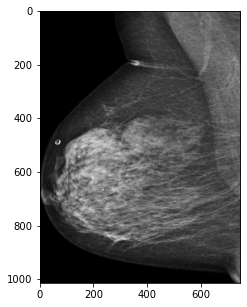

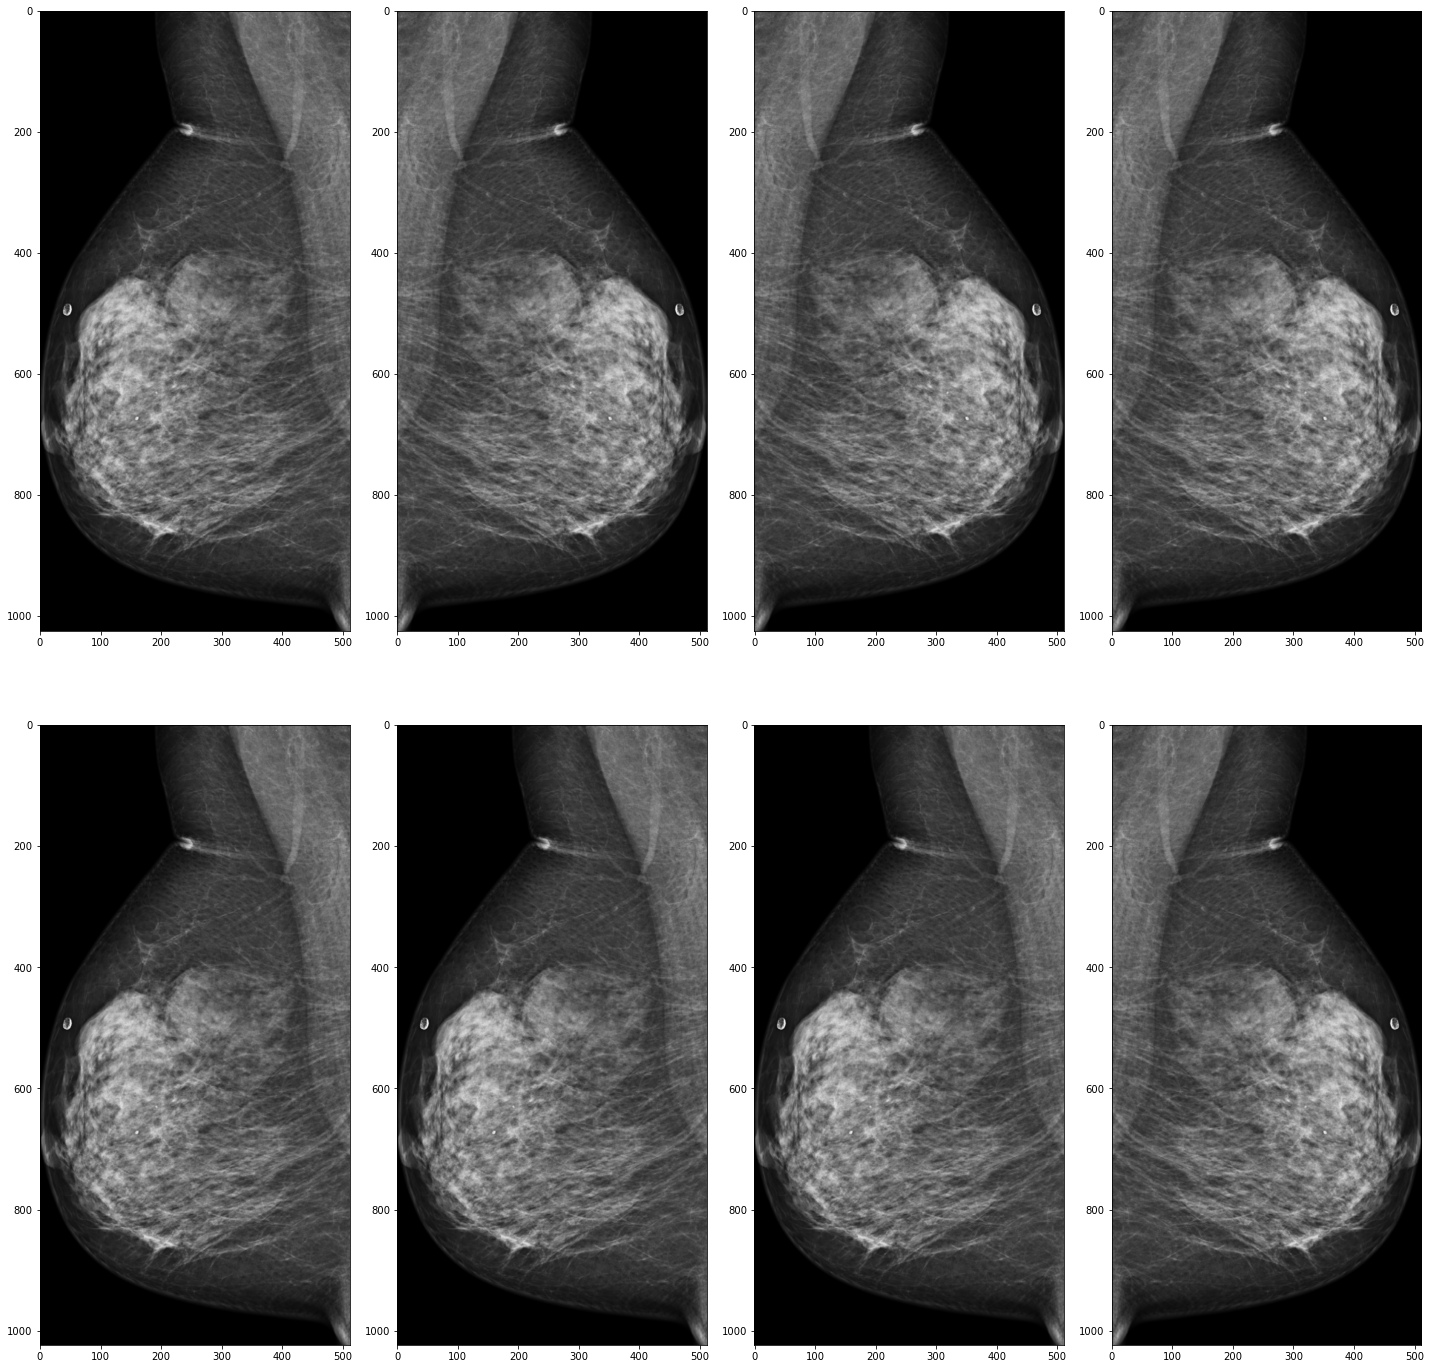

In [51]:
import torchvision
from PIL import Image

def get_transforms(aug=False):

    def transforms(img):
        img = img.convert('RGB')#.resize((512, 512))
        if aug:
            tfm = [
                torchvision.transforms.RandomHorizontalFlip(0.5),
                torchvision.transforms.RandomRotation(degrees=(-5, 5)), 
                torchvision.transforms.RandomResizedCrop((1024, 512), scale=(0.8, 1), ratio=(0.45, 0.55)) 
            ]
        else:
            tfm = [
                torchvision.transforms.RandomHorizontalFlip(0.5),
                torchvision.transforms.Resize((1024, 512))
            ]
        img = torchvision.transforms.Compose(tfm + [            
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=0.2179, std=0.0529),
            
        ])(img)
        return img

    return lambda img: transforms(img)

if DEBUG:
    tfm = get_transforms(aug=False)
    img = Image.open(f"{PNG_TEST_IMAGES_PATH}/test_images/10008/68070693.png")
    plt.imshow(np.array(img), cmap='gray')
    plt.show()

    plt.figure(figsize=(20, 20))
    for i in range(8):
        v = tfm(img).permute(1, 2, 0)
        v -= v.min()
        v /= v.max()
        # plt.imshow(v)
        # break
        plt.subplot(2, 4, i + 1).imshow(v)
    plt.tight_layout()

In [52]:
from PIL import Image


class BreastCancerDataSet(torch.utils.data.Dataset):
    def __init__(self, df, path, transforms=None):
        super().__init__()
        self.df = df
        self.path = path
        self.transforms = transforms

    def __getitem__(self, i):

        path = f'{self.path}/test_images/{self.df.iloc[i].patient_id}/{self.df.iloc[i].image_id}.png'
        try:
            img = Image.open(path).convert('RGB')
        except Exception as ex:
            print(path, ex)
            return None

        if self.transforms is not None:
            img = self.transforms(img)


        return img

    def __len__(self):
        return len(self.df)

ds_test = BreastCancerDataSet(df_test, PNG_TEST_IMAGES_PATH, get_transforms(False))
if DEBUG:
    X, y_cancer, y_aux = ds_test[2]
    print(X.shape, y_cancer.shape, y_aux.shape)

torch.Size([1024, 512]) torch.Size([1024, 512]) torch.Size([1024, 512])


In [58]:
from timm import create_model

class BreastCancerModel(torch.nn.Module):
    def __init__(self, aux_classes, model_type='seresnext50_32x4d', dropout=0.):
        super().__init__()
        self.model = create_model(model_type, pretrained=False, num_classes=0, drop_rate=dropout)

        self.backbone_dim = self.model(torch.randn(1, 3, 512, 512)).shape[-1]

        self.nn_cancer = torch.nn.Sequential(
            torch.nn.Linear(self.backbone_dim, 1),
        )
        self.nn_aux = torch.nn.ModuleList([
            torch.nn.Linear(self.backbone_dim, n) for n in aux_classes
        ])

    def forward(self, x):
        # returns logits
        x = self.model(x)

        cancer = self.nn_cancer(x).squeeze()
        aux = []
        for nn in self.nn_aux:
            aux.append(nn(x).squeeze())
        return cancer, aux

    def predict(self, x):
        cancer, aux = self.forward(x)
        sigaux = []
        for a in aux:
            sigaux.append(torch.softmax(a, dim=-1))
        return torch.sigmoid(cancer), sigaux

if DEBUG:
    with torch.no_grad():
        model = BreastCancerModel(AUX_TARGET_NCLASSES, model_type='seresnext50_32x4d')
        pred, aux = model.predict(torch.randn(2, 3, 512, 512))
        print('seresnext', pred.shape, len(aux))

        model = BreastCancerModel(AUX_TARGET_NCLASSES, model_type='efficientnet_b4')
        pred, aux = model.predict(torch.randn(2, 3, 512, 512))
        print('efficientnet_b4', pred.shape, len(aux))

        # model = BreastCancerModel(AUX_TARGET_NCLASSES, model_type='efficientnetv2_rw_s')
        # pred, aux = model.predict(torch.randn(2, 3, 512, 512))
        # print('efficientnetv2_rw_s', pred.shape, len(aux))

    del model

seresnext torch.Size([2]) 11
efficientnet_b4 torch.Size([2]) 11


In [59]:
def load_model(name, dir='.', model=None):
    data = torch.load(os.path.join(dir, f'{name}'), map_location=DEVICE)
    if model is None:
        model = BreastCancerModel(AUX_TARGET_NCLASSES, data['model_type'])
    model.load_state_dict(data['model'])
    # print(data['threshold'], data['model_type'])
    return model, data['threshold'], data['model_type']

In [60]:
models = []
for fname in tqdm(sorted(os.listdir(MODELS_PATH))):
    model, thres, model_type = load_model(fname, MODELS_PATH)
    model = model.to(DEVICE)
    models.append((model, thres))
    print(f'fname:{fname}, model_type:{model_type}, thres:{thres}')

  0%|          | 0/5 [00:00<?, ?it/s]

fname:model-f0, model_type:seresnext50_32x4d, thres:0.81
fname:model-f1, model_type:seresnext50_32x4d, thres:0.62
fname:model-f2, model_type:seresnext50_32x4d, thres:0.8300000000000001
fname:model-f3, model_type:seresnext50_32x4d, thres:0.93
fname:model-f4, model_type:seresnext50_32x4d, thres:0.67


In [61]:
THRES = 0.91 #max
THRES = 0.69 # mean

In [62]:
def models_predict(models, ds, max_batches=1e9):
    dl_test = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())
    for m, thres in models:
        m.eval()

    with torch.no_grad():
        predictions = []
        for idx, X in enumerate(tqdm(dl_test, mininterval=30)):
            pred = torch.zeros(len(X), len(models))
            for idx, (m, thres) in enumerate(models):
                preds = m.predict(X.to(DEVICE))[0].squeeze()
                pred[:, idx] = preds.cpu()
            predictions.append(pred.mean(dim=-1))
            
            if idx >= max_batches:
                break
        return torch.concat(predictions).numpy()

# Quick test
if DEBUG:
    print(models_predict([(BreastCancerModel(AUX_TARGET_NCLASSES, 'seresnext50_32x4d').to(DEVICE), 0.5),
                    (BreastCancerModel(AUX_TARGET_NCLASSES, 'seresnext50_32x4d').to(DEVICE), 0.1)], ds_test, max_batches=2))

  0%|          | 0/1 [00:00<?, ?it/s]

[0.49072725 0.49191165 0.49276453 0.49226275]


In [63]:
models_pred = models_predict(models, ds_test)

  0%|          | 0/1 [00:00<?, ?it/s]

In [64]:
df_test['cancer'] = models_pred

df_sub = df_test.groupby('prediction_id')[['cancer']].mean()
df_sub

,cancer
prediction_id,
10008_L,0.143151
10008_R,0.128062


In [65]:
df_sub['cancer'] = (df_sub.cancer > THRES).astype(float)
df_sub

,cancer
prediction_id,
10008_L,0.0
10008_R,0.0


In [66]:
df_sub.to_csv('submission.csv', index=True)
!head submission.csv

prediction_id,cancer
10008_L,0.0
10008_R,0.0
